https://github.com/isaaccorley/torchrs#rams

In [ ]:
# !git clone https://github.com/isaaccorley/torchrs

In [ ]:
# !chmod +x torchrs/scripts/download_probav.sh

In [ ]:
# !torchrs/scripts/download_probav.sh

In [ ]:
ls -a

In [1]:
import torch

from torchrs.transforms import Compose, ToTensor
from torchrs.datasets import PROBAV
from torchrs.models import RAMS

import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = Compose([ToTensor()])

dataset = PROBAV(
    root=".data/probav/",
    split="train",          # or 'test'
    band="RED",             # NIR or RED
    lr_transform=transform,
    hr_transform=transform
)

In [3]:
len(dataset)

594

In [4]:
dataset[0].keys()

dict_keys(['lr', 'qm', 'hr', 'sm'])

        lrs: (t, 1, h, w) low resolution images
        qms: (t, 1, h, w) low resolution image quality masks
        hr: (1, h, w) high resolution image
        sm: (1, h, w) high resolution image status mask
        Note:
        lr/qm original size is (128, 128),
        hr/sm original size is (384, 384) (scale factor = 3)
        t is the number of lr images for an image set (min = 9)

In [5]:
def get_ds_stack(ds_index: int) -> int:
    return dataset[ds_index]['lr'].shape[0]

In [41]:
%%time
target_stack = 15
index = None

stack_t = []
for i in range(len(dataset)):
    stack_t.append(get_ds_stack(i))
    if get_ds_stack(i) == target_stack:
        print(f"Frame {i} has stack {target_stack}")
        index = i
        break

Frame 2 has stack 15
CPU times: user 130 ms, sys: 13.6 ms, total: 144 ms
Wall time: 168 ms


Index 2 contains 15 lr images


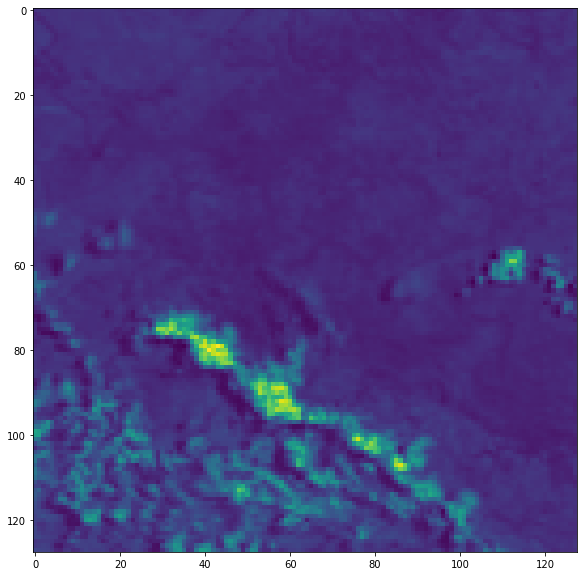

In [36]:
print(f"Index {index} contains {get_ds_stack(index)} lr images")

x = dataset[index]
res = 'lr' # or 'hr'

if res == 'hr':
    data = np.array(x[res][0,:,:])
elif res == 'lr':
    data = np.array(x[res][0,0,:,:])

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(data);

In [38]:
stack_size = x['lr'].unsqueeze(0).shape[1]
print(stack_size)

model = RAMS(
    scale_factor=3,
    t=stack_size,
    c=1,
    num_feature_attn_blocks=12
)

15


In [39]:
lr_frame = x['lr'].unsqueeze(0).to(dtype=torch.float32)
lr_frame.shape

torch.Size([1, 15, 1, 128, 128])

torch.Size([1, 1, 384, 384])
CPU times: user 19.8 s, sys: 933 ms, total: 20.8 s
Wall time: 20.2 s


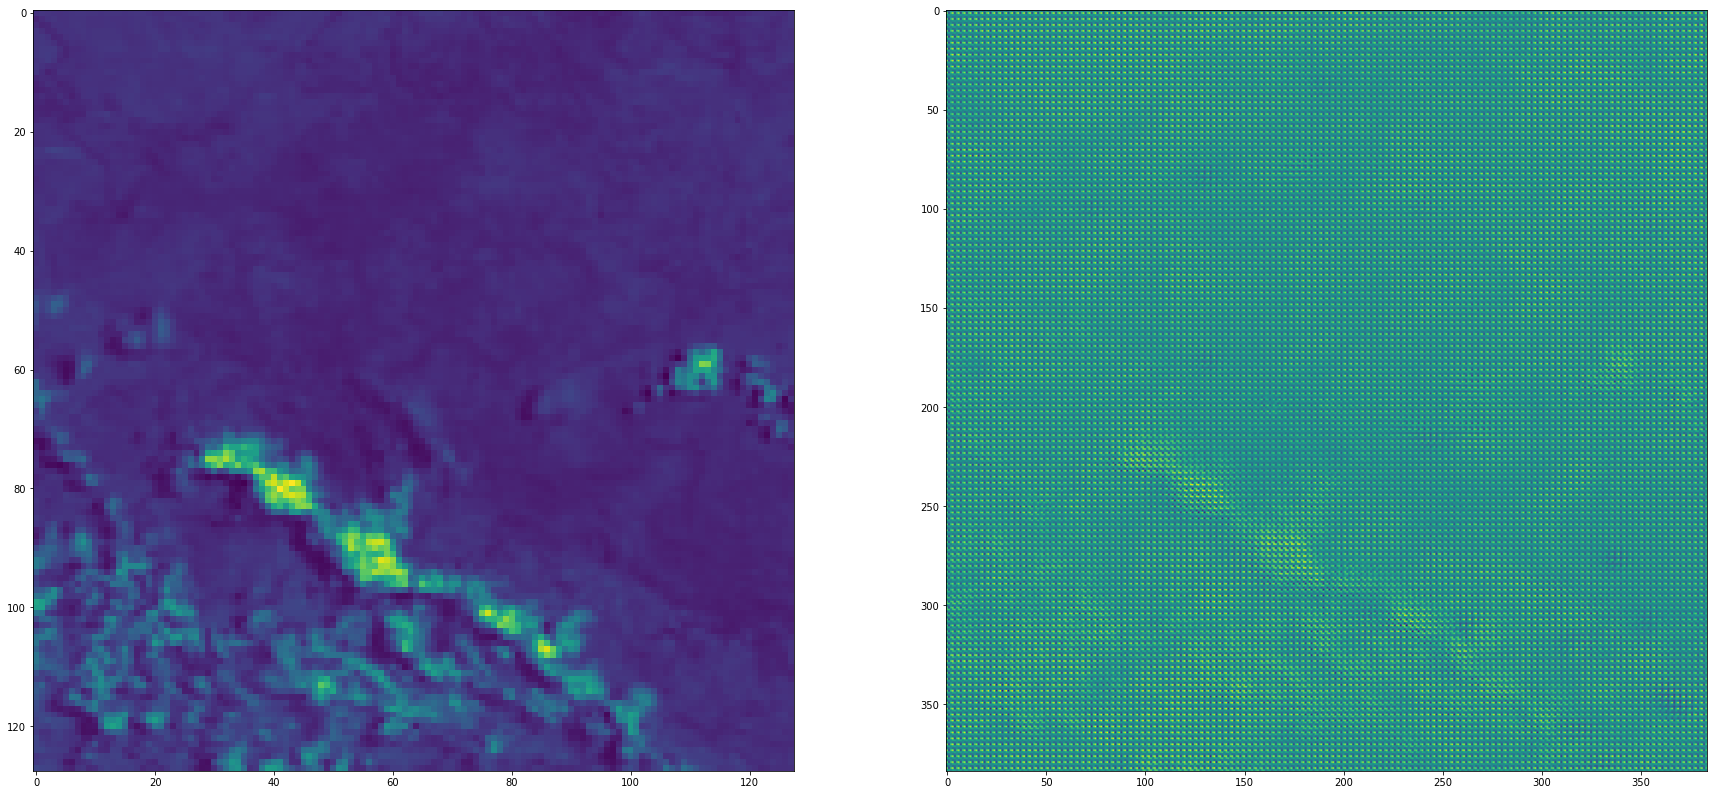

In [40]:
%%time
sr = model(lr_frame)

print(sr.shape)

in_data = np.array(lr_frame[0,0,0,:,:])
# out_data = sr.squeeze().detach().numpy() # fails for Invalid shape (2, 384, 384) for image data
out_data = sr[0,0,:,:].detach().numpy()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(30,30))
ax1.imshow(in_data)
ax2.imshow(out_data);

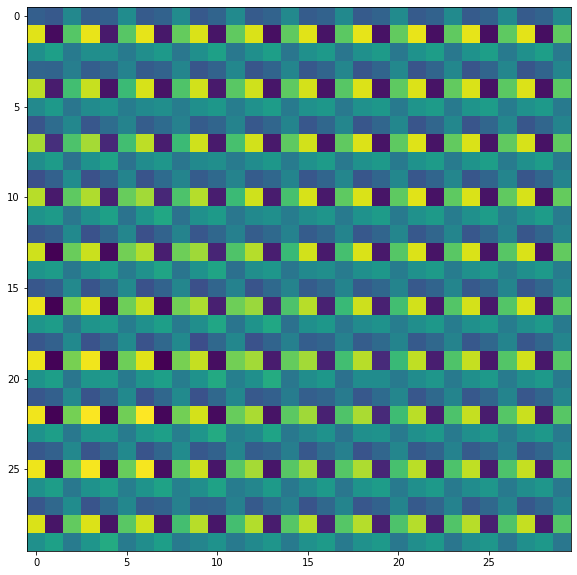

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(out_data[:30, :30]);